# 作业

本次作业主要涉及两种参数估计方法(MLE+MCMC)和强化学习(dynamic programming+Sarsa)

## Part 1 参数估计之MLE
* 采用`exampledata.txt`的数据

* 请使用example.txt。一共有3000个试次, 每一行是一个试次的数据
* 其中1-3列分别是：
    - coherence(运动序列。共5种coherence[0.032, 0.064, 0.128, 0.256, 0.52])
    - response time (总反应时长)
    - correct(1, 正确; 0, 错误)
* example.txt的形状为(3000, 3)

In [ ]:
# load  data
import numpy as np
data = np.loadtxt('example.txt')
nTrial = data.shape[0] # how many trials
eps = np.finfo(float).eps

###

**Q1.1: 请写出ddm的负对数似然函数`negloglikeli`(negative log-likelihood function)**

* 请利用ddm的函数`ddmpdf`


`def ddmpdf(k, a, B, ndt, coh, correct, rt):`

* 该函数接受七个参数, 其中四个是ddm的参数
    
  - k: drift rate
  - a: initial bias,范围是(0,1)
  - B: decision boundary
  - ndt: non-decision time
   
* 另外三个是一个trial的数据
  - coh: coherence
  - correct: correct 1 or not 0
  - rt: reaction time in secs


In [ ]:
from ddm import ddmpdf
import numpy as np
eps = np.finfo(float).eps
# define a negative log-likelihood objective function
def negloglikeli(params, data):
    '''
    <params>:(4,) array, drift rate, decision boundary, initial bias, non-decision time
    '''
    k = params[0] # drift rate
    B = params[1] # decision boundary
    a = params[2] # initial bias (0, 1)
    ndt = params[3] # non-decision time
    
    nTrial = data.shape[0] # trial数量
    pp = np.empty(nTrial)
    for i in range(nTrial): # 循环trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp_valid=0.999*pp + eps # 避免概率为0
    return -np.log(pp_valid).sum() # 对数求负

###

**Q1.2: 利用最大似然估计(maximum likelihood estimation)的方法求解ddm模型参数k,B,a,ndt**
* 参数k,B,a,ndt的bounds分别为((0, 20), (0, 5), (0, 1), (0, 1))


In [ ]:
np.random.seed(1234)
from scipy.optimize import minimize

res = minimize(fun=negloglikeli, x0=(1.6, 2.3, 0.5, 0.01), args=(data),bounds=((0, 20), (0, 5), (0, 1), (0, 1)))

print('fitted drift coefficient is ', res.x[0])
print('fitted decision boundary is ', res.x[1])
print('fitted initial bias is ', res.x[2])
print('fitted nondecision time is ', res.x[3])

正确答案如下：

fitted drift coefficient is  1.311973225181628

fitted decision boundary is  2.3928813293564226

fitted initial bias is  0.44777115298949804

fitted nondecision time is  0.15575902656319945

## Part 2 参数估计之MCMC

###
**Q2: 利用Metropolitan-Hasting的方法估计DDM模型中的参数：drift rate (k).不能借助工具包，必须手写M-H**
* 请使用example.txt。
* 将DDM中其余参数固定为： 
    - B(boundary) = 2
    - a(initial bias) = 0.5
    - ndt(non-decision time) = 0.1
* (代码中已经固定randomseed，每一次结果都将一致。请勿修改)
* hint：
    - 提议分布建议使用正态分布。正态分布可以使用scipy.stats.norm()
    - 从提议分布中每一次采样，起始值都设置为每一次循环最开始的初始化参数值
    - 从提议分布中采样的结果通过exp()转换（因为drift rate始终大于零）
    - $\min[\frac{f(x)}{f(y)}, 1]$ 可以被表示为 $\min[\log(f(x))-\log(f(y)), 0]$

In [ ]:
# 首先写好loglikehood func（不用取负值）
import numpy as np
from ddm import ddmpdf
eps = np.finfo(float).eps
def loglikeli(k, data):
    '''
    共有四个参数。其中：
    <k>:    drift rate
    <B>:    decision boundary
    <a>:    initial bias
    <ndt>:  non-decision time
    <data>: 输入的数据。来自example.txt
    注意:除了k以外的剩下三个参数(B,a,ndt)均已被固定
    '''
    B = 2 # decision boundary
    a = 0.5# initial bias (0, 1)
    ndt = 0.1 # non-decision time
    nTrial = data.shape[0] # 试次数量
    pp = np.empty(nTrial)
    for i in range(nTrial): # 循环试次
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp_valid = 0.999*pp + eps  
    return np.log(pp_valid).sum() # 对数求和

In [6]:
from scipy.stats import norm, uniform
import numpy as np
#proposal dist 为gamma分布.使得drift rate始终大于零
def metropolis_hastings(data, y_k, n_sample=3000, n_burnin=1000, random_seed=1234):
    '''
    <data>:         需要加载的数据,example.txt
    <y_k>:          先初始化一个k
    <n_sample>:     需要采样的次数
    <n_burin>:      需要被丢弃的采样数量
    <randomseed>:   随机种子。用于重现结果
    
    '''    
    np.random.seed(random_seed)
    samples = []
    B = 2 # decision boundary
    a = 0.5# initial bias (0, 1)
    ndt = 0.1 # non-decision time
    nTrial = data.shape[0] # how many trials
    init_k = y_k  # 初始化你要估计的参数

    for i in range(n_sample + n_burnin):
        # 从提议分布中采样
        pro_k = np.exp(norm(loc=init_k,).rvs())
        # 由于k始终大于零，所以需要进行指数函数的转换
        
        # 计算对数似然
        loglik_proposed = loglikeli(pro_k, data)
        loglik_init = loglikeli(init_k, data)
        
        # 计算接受率
        a_log = np.min([0, (loglik_proposed-loglik_init)])
        # 接受或拒绝 
        u_log = np.log(uniform.rvs(0,1))
        if u_log < a_log:
            samples.append(pro_k)   # 接受并跳转到新的sample
            init_k = pro_k
        else:samples.append(init_k) # 保留原来那个sample不变
    return samples

# 设置初始参数值
y_k = 0.1

# 调用 Metropolis-Hastings 算法
samples = metropolis_hastings(data, y_k)


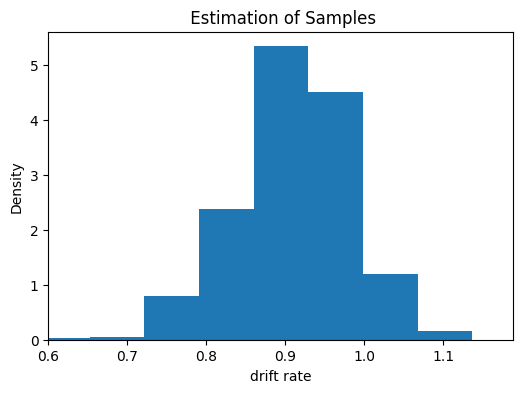

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.hist(samples, bins=15, density=True, label='samples')
plt.xlabel('drift rate')
plt.xlim(0.6)
plt.xticks([0.6,0.7,0.8,0.9,1.0,1.1])
plt.ylabel('Density')
plt.title(' Estimation of Samples')
plt.show()

正确答案近似下图

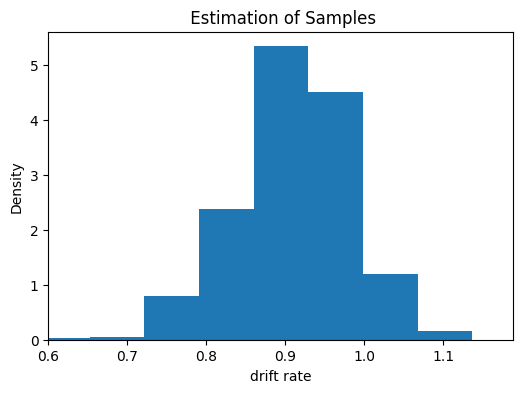

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.hist(samples, bins=15, density=True, label='samples')
plt.xlabel('drift rate')
plt.xlim(0.6)
plt.xticks([0.6,0.7,0.8,0.9,1.0,1.1])
plt.ylabel('Density')
plt.title(' Estimation of Samples')
plt.show()

## Part 3 强化学习之dynamic programming

### 
我们接下来的游戏需要借助一个冰湖任务完成。这个游戏的规则很简单：掉进蓝色冰窟窿内即失败(游戏结束)；顺利到达goal(G)即成功(游戏结束)。
在这个冰湖环境中，agent的动作为：
* 0: 上
* 1: 下
* 2: 左
* 3: 右
##### 先来看看我们已经拥有的冰湖任务的环境。

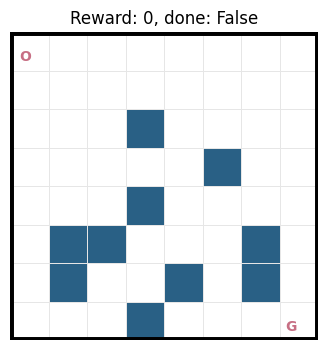

In [9]:
from utils.env import frozen_lake
import matplotlib.pyplot as plt

seed = 1234
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

###
**Q3：完成value iteration。**
完成value iteration的步骤(伪代码)：

1. 输入一个初始policy $(\pi)$
2. 输入一个极小值 $\theta >0$ 
3. 为除了终点的所有状态$(s)设置初始值V(s)$
4. 循环
    1. $ \Delta  ← 0$
    2. 遍历每一个状态空间 s ∈ States
        1. $ v ← V(s)$
        2. $ V(s) ← \max\limits_{a} \sum\limits_{s'} p(s'|s, a) * [R(s') + \gamma * V(s')]$
        3. $\Delta ← \max(\Delta , |v - V(s)|)$
- 直到 $\Delta  < \theta$，停止循环
5. $ \pi(s) = \argmax\limits_{a}\sum\limits_{s'} p(s'|s, a) * [R(s') + \gamma * V(s')]$
6. 返回 $V,\pi$
    
hint：
* 可以使用`env.r()`获取下一个状态的reward
* 可以使用`env.p_s_next()`来获取状态转移概率
* 可以借助`np.eye()`来找到能返回最大值的action



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from utils.viz import viz 
viz.get_style()

def value_iter(env, seed=1234, theta=1e-4, gamma=.99, show_update=False):
    '''
    <env>:   冰湖环境
    <seed>:  随机种子
    <theta>: 极小值，用于和Δ比较，判断收敛
    <gamma>: 折扣因子
    <show_update>: 更新过程的展示（默认为否，我们直接看结果即可）
    '''
    rng = np.random.RandomState(seed)
    # 任意初始化 V(s), 但 V(terminal)=0
    V = rng.rand(env.nS) * 0.001
    # except v(terminal) = 0
    for s in env.s_termination:
        V[s] = 0
    # init policy 
    pi = np.zeros([env.nS, env.nA])
    # 循环直至收敛（delta < theta）
    while True:
        delta = 0
        for s in env.S:
            v_old = V[s].copy()
            q = np.zeros([env.nA])
            for a in env.A:
                p = env.p_s_next(s, a)                                  # 获取在当前状态下的transition function
                for s_next in env.S:
                    r, done = env.r(s_next)                             # 获取下一步进入状态s_next获得的reward
                    q[a] += p[s_next]*(r + (1-done)*gamma*V[s_next])    # 根据公式更新Q值
            V[s] = np.max(q)                                            # V(s)就是状态空间下的最大值
            pi[s] = np.eye(env.nA)[np.argmax(q)]                        
            delta = np.max([delta, np.abs(V[s] - v_old)])

        # 可视化 
        if show_update:
            _, axs = plt.subplots(1, 2, figsize=(8, 4))
            clear_output(True)
            ax = axs[0]
            env.show_v(ax, V)
            ax = axs[1]
            env.show_pi(ax, pi)
            time.sleep(.1)
            plt.show()

        # 判断收敛
        if delta < theta: break 

    for s in env.s_termination:
        V[s] = 0
    return V, pi 
        

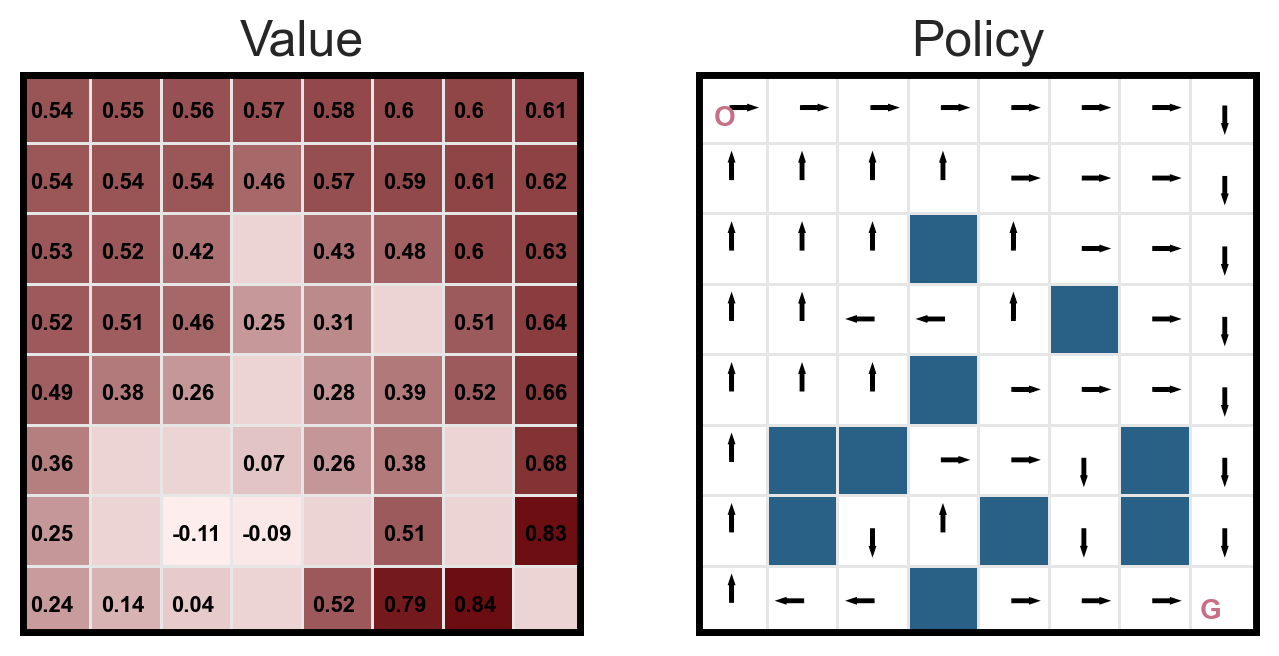

In [11]:
import matplotlib.pyplot as plt
from utils.viz import viz 
viz.get_style()
from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 可视化
V2, pi2 = value_iter(env)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V2)
ax = axs[1]
env.show_pi(ax, pi2)
plt.show()

正确答案近似下图

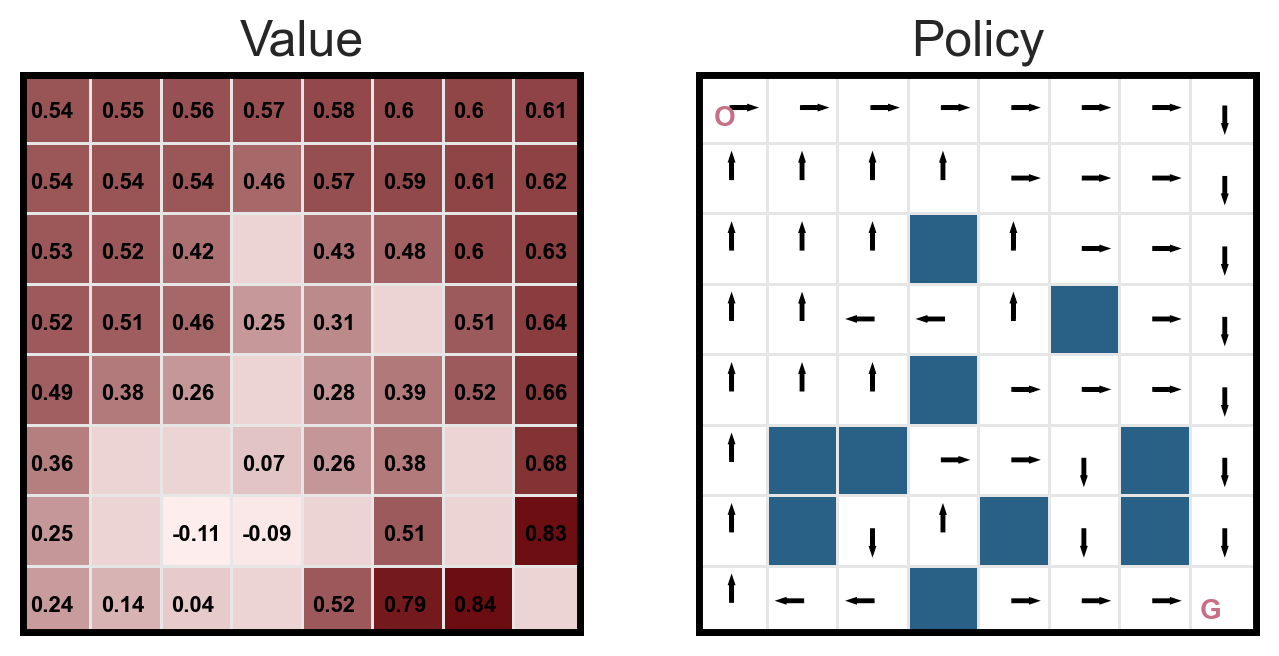

## Part 4 强化学习中之 sarsa (TD-learning)
课堂上我们讲的内容是Q-learning。SARSA和Q-learning都属于强化学习中的TD-learning范畴，因为它们都使用了时序差分学习(TD-learning)的思想来更新值函数。虽然它们的目标相同，但它们在更新策略上有一些不同之处。

1. **目标**：
   - Q-learning的目标是学习最优的状态-动作值函数Q，并根据该值函数选择动作。它基于下一状态下所有可能动作的最大值更新。
   - SARSA的目标是学习最优的状态-动作值函数Q，并根据该值函数选择动作。它基于当前状态-动作对的值更新。

2. **更新策略**：
   - 在Q-learning中，Q值的更新考虑当前状态下采取的动作($a_t$),以及下一个状态下的最大价值$\left(\underset{a}{\max}Q^{\pi}{(s_{t+1},a)}\right)$。具体地说，更新公式为：
  
      $Q^{\pi}{(s_t,a_t)} = Q^{\pi}{(s_t,a_t)} + \alpha * \left[r + \gamma*\underset{a}{\max}Q^{\pi}{(s_{t+1},a)}-Q^{\pi}{(s_t,a_t)}\right]$
   - 在SARSA中，Q值的更新考虑了当前状态下采取的动作$(Q^{\pi}{(s_t,a_t)})$以及在下一个状态下采取的动作$(Q^{\pi}{(s_{t+1},a_{t+1})})$。具体地说，更新公式为：
  
      $Q^{\pi}{(s_t,a_t)} = Q^{\pi}{(s_t,a_t)} + \alpha * \left[r + \gamma* Q^{\pi}{(s_{t+1},a_{t+1})}-Q^{\pi}{(s_t,a_t)}\right]$
   
   - 其中，$(s_{t})$是当前状态，$(a_{t})$是当前动作，$(r)$是获得的奖励，$(s_{t+1})$是下一个状态，$(a_{t+1})$是下一个状态下采取的动作，$(\alpha) $是学习率，$(\gamma)$是折扣因子。



### 
**Q4：补充sarsa 代码**

我们来看一下实现Sarsa的步骤：
1. 遍历每一个episode (episode = 1 to 总episodes):
    1. 初始化状态 s
    2. 基于$Q(s, a)$，根据e-greedy policy来选择action
    3. 循环（检测收敛）
        1. $采取 action (a)$, $观察到 reward  (r)$  $下一个状态$ next  state $ ( s_{t+1})$
        2. $采取下一个动作 action (a_{t+1})。基于Q(s_{t+1}, a_{t+1})，根据$ e-greedy policy $来选择下一个action $
        3. $Q(s, a) ← Q(s, a) + \alpha * [r + \gamma * Q(s_{t+1}, a_{t+1}) - Q(s, a)] $
        4. $s ← s_{t+1}$    记录状态，s_next $(s_{t+1})为s$
        5. $a ← a_{t+1}$    记录动作，a_next $(a_{t+1})为a$
    - 直到s到达终点，停止循环

2. episode loop 结束，return $Q$

hint
* episode是指训练的总次数
*  这一步：$Q(s, a) ← Q(s, a) + \alpha * \left[r + \gamma * Q(s_{t+1}, a_{t+1}) - Q(s, a)\right]$ ，需要考虑下一个状态是否为done(终点)。如为终点，下一步$Q(s_{t+1}, a_{t+1})$不存在，写法见课堂Q-learning代码

In [13]:
import random
import numpy as np
seed = 1234
rng = np.random.RandomState(seed)

def e_greedy(q, rng, env, eps):
    a_max = np.argwhere(q==np.max(q)).flatten()
    policy = np.sum([np.eye(env.nA)[i] for i in a_max], axis=0) / len(a_max)
    if rng.rand() < 1-eps:
        a = rng.choice(env.nA, p=policy)
    else:
        a = rng.choice(env.nA)
    return a 

In [14]:
import numpy as np
from IPython.display import clear_output
from utils.viz import viz 
viz.get_style()

def Sarsa(env, alpha=.2, eps=.1, gamma=.99, max_epi=5000, seed=1234, theta=1e-4):
    '''
    <env>:当前所属冰湖环境
    <alpha>:     学习率
    <eps>:       在 e_greedy中用于随机性结果判断
    <gamma>:     折扣因子
    <max_epi>:   最大训练次数
    <seed>:      随机种子,确保每次结果可重现
    <theta>:     极小值，用于和Δ比较，判断收敛
    '''
    rng = np.random.RandomState(seed)
    # initialize Q
    Q = np.zeros([env.nS, env.nA])
    for _ in range(max_epi):
        G = 0
        q_old = Q.copy()
        s, _, done = env.reset()
        # 采样At, 观察到 Rt和 St+1
        a = e_greedy(Q[s, :], rng, env, eps)
        while True:
            s_next, r, done = env.step(a)
            a_next = e_greedy(Q[s_next, :], rng, env, eps)
            Q_tar  = r + (1-done)*gamma*(Q[s_next, a_next])         # 根据Sarsa更新公式更新目标Q值
            Q[s,a] += alpha*(Q_tar-Q[s,a])                          # 更新Q值
            s = s_next                                              #记录s_next为s
            a = a_next                                              #记录a_next为a
            G += r
            if done:
                break 
        delta = np.max(np.abs(q_old - Q))                           #计算delta值
        if (delta < theta).all():
            break
    pi = np.eye(env.nA)[np.argmax(Q, axis=1)]
    return Q, pi

In [ ]:
## 可视化
import numpy as np
import matplotlib.pyplot as plt
import time
from utils.viz import viz 
viz.get_style()
from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

Q_sarsa, pi_sarsa = Sarsa(env)
V3 = Q_sarsa.max(1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V3)
ax = axs[1]
env.show_pi(ax, pi_sarsa)
plt.show()

正确答案近似下图

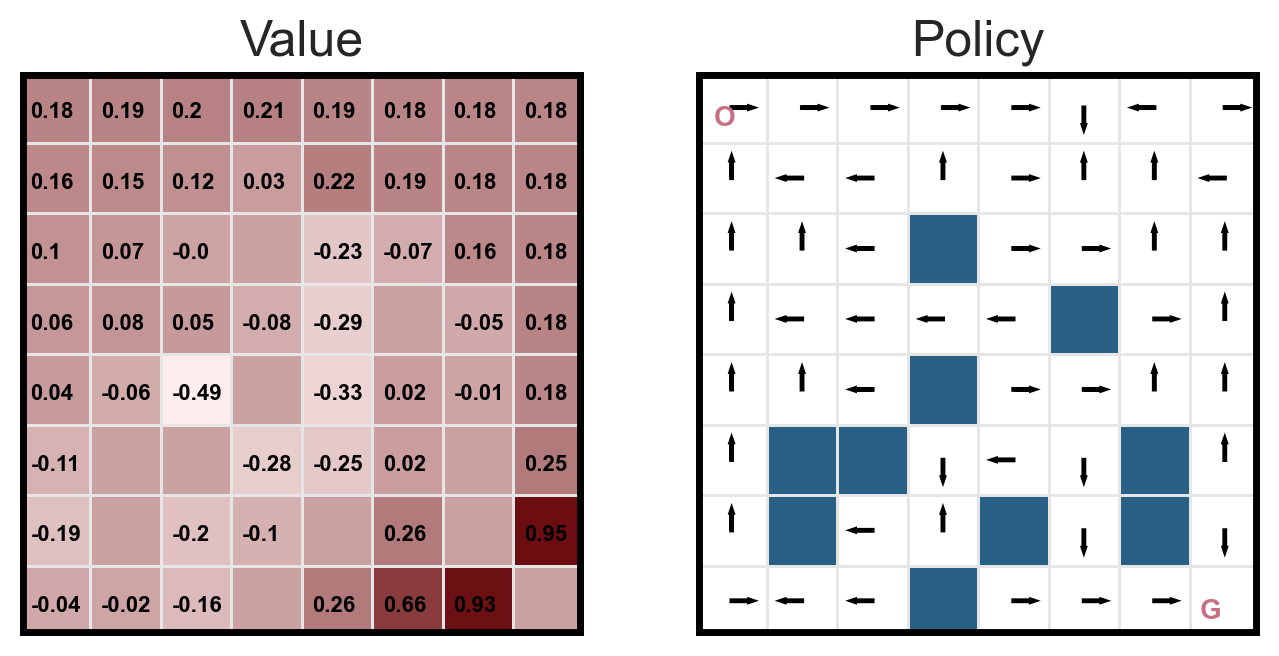